# Zeitlicher Ablauf der Datenerfassung mit Bildern 

Thema
 ------
 
 In diesem Jupyter Notebook geht es, um die Darstellung eines Ausschnitts der Datenerfassung von der Android TN Fahrradwege Monitoring App. Dabei werden die tatsächlichen Zeitlichen Ereignisse genutzt.

In [95]:
# Import von Bibliotheken
import os
import pandas
import numpy as np
import cv2
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.ticker as FormatStrFormatter
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)

In [2]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("../daten/merkmale.csv")
featuresDf.describe()

,Zeitstempel in Unixzeit,Breitengrad,Laengengrad,Geschwindigkeit in km/h,Hoehe in m ueber WGS 84,Anzahl der Messwerte,Start des Zeitfensters in ns seit Start der JVM,Start der Messwerterfassung in ns seit Start der JVM,Start der Belichtung in ns seit Start der JVM,Belichtungszeit in ns,...,Varianz X-Achse Beschleunigung in m/s^2,Varianz Y-Achse Beschleunigung in m/s^2,Varianz Z-Achse Beschleunigung in m/s^2,Varianz Nick in rad,Varianz Roll in rad,Standardabweichung X-Achse Beschleunigung in m/s^2,Standardabweichung Y-Achse Beschleunigung in m/s^2,Standardabweichung Z-Achse Beschleunigung in m/s^2,Standardabweichung Nick in rad,Standardabweichung Roll in rad
count,1.935000e+03,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1.935000e+03,1.935000e+03,1.935000e+03,1.935000e+03,...,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000
mean,1.521815e+12,53.611756,10.141385,15.431479,70.983613,19.335401,1.232928e+14,1.232927e+14,1.232928e+14,1.717044e+07,...,5.090925,40.109086,47.298581,0.453278,0.755017,1.843783,4.890581,5.664694,0.604631,0.617375
std,1.711999e+05,0.001963,0.004292,2.578698,2.540434,0.574053,1.712002e+11,1.712002e+11,1.712005e+11,5.915285e+06,...,9.928539,84.530317,74.631600,0.415298,1.384871,1.300870,4.024882,3.900985,0.296218,0.611603
min,1.521815e+12,53.608086,10.136243,6.012000,64.299440,14.000000,1.229923e+14,1.229923e+14,1.229924e+14,1.000184e+07,...,0.051570,0.293240,0.390830,0.004730,0.001030,0.227090,0.541520,0.625160,0.068770,0.032090
25%,1.521815e+12,53.610050,10.137212,14.256000,69.145140,19.000000,1.231447e+14,1.231447e+14,1.231448e+14,1.000184e+07,...,0.955515,5.312705,8.138980,0.129180,0.027425,0.977505,2.304930,2.852890,0.359415,0.165605
50%,1.521815e+12,53.612152,10.140454,15.768001,71.069275,19.000000,1.232957e+14,1.232956e+14,1.232957e+14,2.000368e+07,...,2.177540,13.362630,20.536700,0.327060,0.113760,1.475650,3.655490,4.531740,0.571890,0.337280
75%,1.521815e+12,53.613777,10.145028,17.208002,72.942380,20.000000,1.234378e+14,1.234377e+14,1.234378e+14,2.000368e+07,...,5.343015,33.826275,52.282975,0.663675,0.834570,2.311500,5.816035,7.230695,0.814660,0.913545
max,1.521815e+12,53.613907,10.149695,20.268002,77.023680,22.000000,1.235899e+14,1.235898e+14,1.235899e+14,2.999632e+07,...,190.706400,1037.005440,998.218210,2.811090,12.292420,13.809650,32.202570,31.594590,1.676630,3.506050


In [67]:
featuresDf.columns

(1935, 35)

In [4]:
%%time
# Lade Messwerte 
accXDf = pandas.read_csv("../daten/x-Achse-Beschleunigungswerte.csv")
accXDf.drop(['index'],axis=1 ,inplace=True)
accYDf = pandas.read_csv("../daten/y-Achse-Beschleunigungswerte.csv")
accYDf.drop(['index'],axis=1 ,inplace=True)
accZDf = pandas.read_csv("../daten/z-Achse-Beschleunigungswerte.csv")
accZDf.drop(['index'],axis=1 ,inplace=True)
pitchDf = pandas.read_csv("../daten/nick-Messwerte.csv")
pitchDf.drop(['index'],axis=1 ,inplace=True)
rollDf = pandas.read_csv("../daten/roll-Messwerte.csv")
rollDf.drop(['index'],axis=1 ,inplace=True)
azimuthDf = pandas.read_csv("../daten/azimuth-Messwerte.csv")
azimuthDf.drop(['index'],axis=1 ,inplace=True)
sensorTimestampsDf = pandas.read_csv("../daten/sensorevent-Zeitstempel.csv")
sensorTimestampsDf.drop(['index'],axis=1 ,inplace=True)

Wall time: 108 ms


In [160]:
# Index von welchem die Messwerte dargestellt werden sollen
row = 420
# Der erste und letzte Zeitstempel der Messwerterfassung
sensorTimestamps =  sensorTimestampsDf.iloc[row] / 1000000
timestampsMinMax = [sensorTimestampsDf.iloc[row,0]/ 1000000,sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any').iloc[0,-1]/ 1000000]
# Belichtungszeit vom Start bis zum Ende
startExposureTime = featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row]-featuresDf['Start des Zeitfensters in ns seit Start der JVM'].iloc[row]
exposureTime = [startExposureTime/1000000,startExposureTime/1000000 + featuresDf['Belichtungszeit in ns'].iloc[row]/1000000]

In [161]:
[featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row]/1000000,featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row]/1000000 + featuresDf['Belichtungszeit in ns'].iloc[row]/1000000]

[123123697.05645899, 123123707.05829799]

In [162]:
# Lade Bilder in eine Liste
images = []
# Hier können die Datensätze ausgewählt werden
datasets = ['18']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []

In [163]:
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("E:/bachelor/daten/" + dataset + "/zugeschnitten/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        files = os.listdir(filesPath)
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            images.append(cv2.imread(filesPath + name)) # Bild wird gelesen

In [164]:
def formatter(y, pos):
    if y == 1:
        return 'Nick Lagewinkel'
    if y == 2:
        return 'Z-Achse Beschleunigungssensor'
    if y == 3:
        return 'Belichtungszeit'
    if y == 4:
        return 'Bildaufnahme'
    else:
        return ''

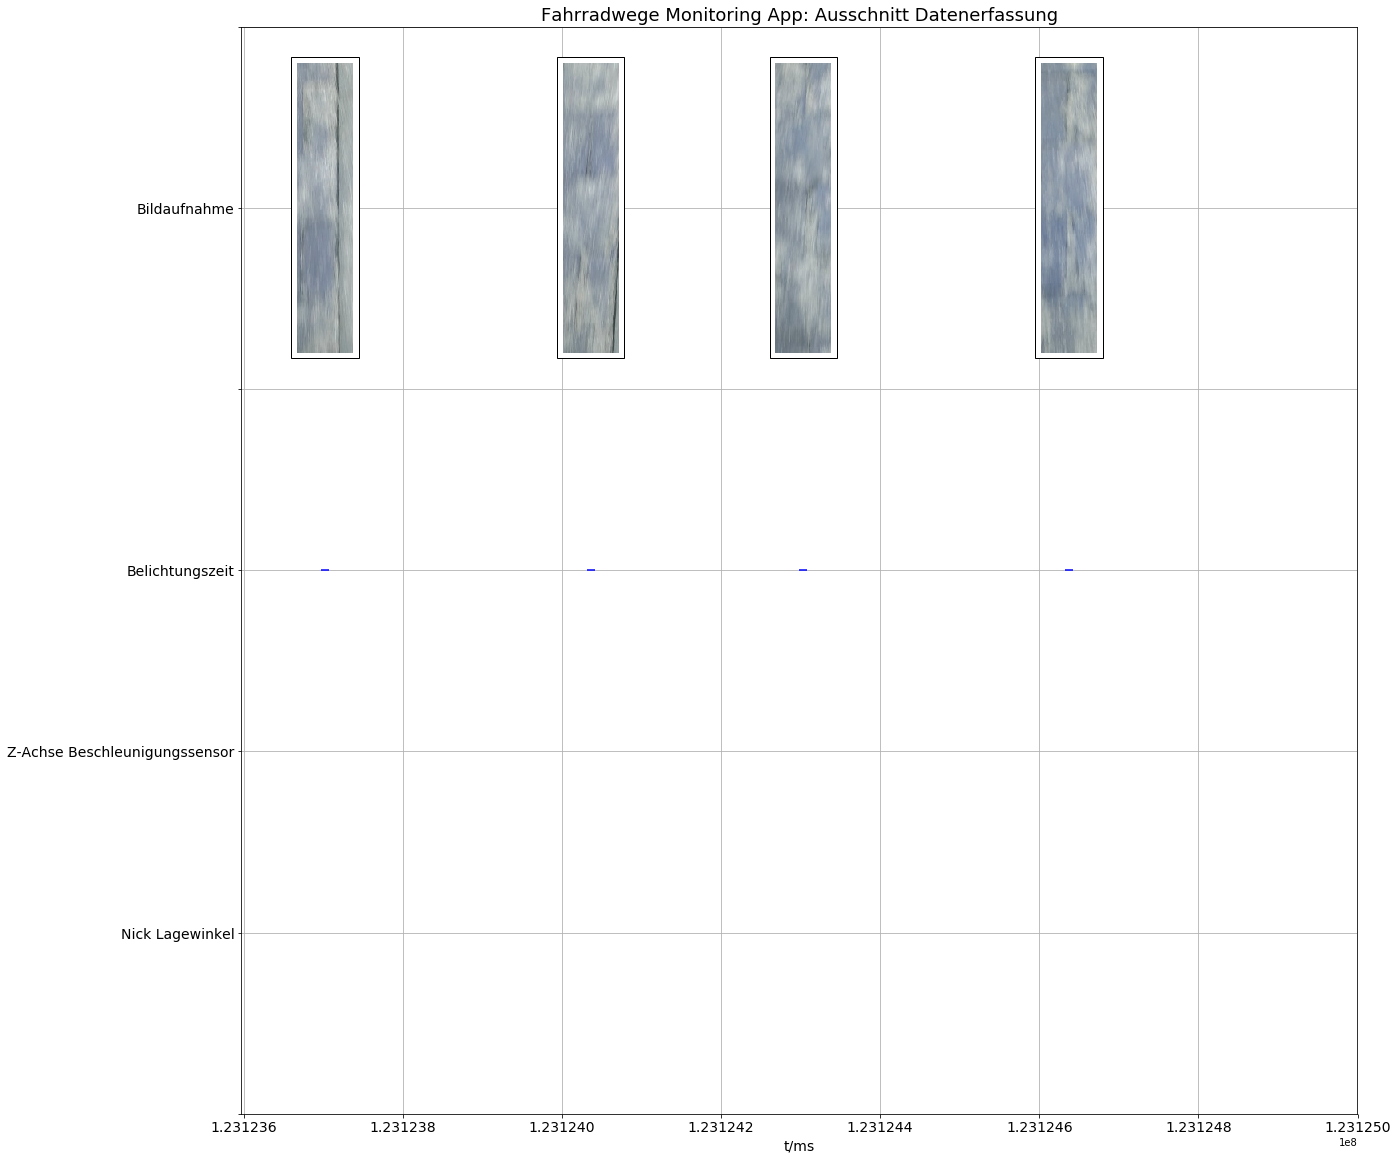

In [189]:
# Plot mit Gantt-Diagram
fig, ax = plt.subplots(figsize=(20,20))
i = 0
numberImages = 4
while i < numberImages:
        # Belichtungszeit
        ax.hlines(xmin=(featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row+i])/1000000,
                    xmax=featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row+i]/1000000+featuresDf['Belichtungszeit in ns'].iloc[row+i]/1000000,y=3, colors='blue')
        xy = [(featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row+i]+featuresDf['Belichtungszeit in ns'].iloc[row+i]/2)/1000000, 5]
        imagebox = OffsetImage(images[row+i], zoom=0.8)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, xy,
                        xybox=(0., 0.),
                        xycoords='data',
                        boxcoords="offset points"
                        )
        ax.add_artist(ab)
        i = i + 1



def formatter(y, pos):
    if y == 1:
        return 'Nick Lagewinkel'
    if y == 2:
        return 'Z-Achse Beschleunigungssensor'
    if y == 3:
        return 'Belichtungszeit'
    if y == 5:
        return 'Bildaufnahme'
    else:
        return ''

ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('t/ms',fontsize=14)
plt.title('Fahrradwege Monitoring App: Ausschnitt Datenerfassung',fontsize=18)
plt.grid()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(0,6)
plt.xlim(featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row]/1000000-100,featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row+i]/1000000)
plt.rcParams["legend.fontsize"] = 14